# Предсказание температуры стали

Для оптимизации производственных расходов металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

Технологический процесс выглядит следующим образом:
1. Расплавленную сталь заливают в ковш и нагревают до нужной температуры графитовыми электродами.
2. Производят десульфурацию.
3. Производят замер температуры и химический анализ стали.
4. Повышают температуру на несколько минут и вводят легирующие добавки (сыпучие или проволочные материалы).
5. Продувают сплав инертным газом.
6. Перемешивают сплав, снова производят замер температуры и химический анализ стали.
7. При необходимости повторяют пп. 3...6 до достижения целевого химического состава и оптимальной температуры плавки.
8. Сталь поступает в машину непрерывной разливки, откуда выходит готовый продукт в виде заготовок-слябов.

Заказчик настаивает на том, что все полученные данные реальные и хотел бы получить модель, обученную на максимально полном объёме данных. При этом в данных могут быть нестыковки по времени выполнения операций - это особенности получения и записи информации с датчиков.

**План работы**

1. Исследовательский анализ данных.


2. Предобработка данных:
- агрегация данных по ключам и создание новых признаков;
- работа с пропусками;
- создание сводной таблицы.
3. Обучение моделей и выбор лучшей:
- простые модели;
- модель градиентного бустинга;
- константная модель для проверки адекватности.
4. Проверка качества модели на тестовой выборке.

## 1 Исследовательский анализ данных

Импортируем все необходимые для работы библиотеки, откроем файлы с данными и изучим общую информацию о них.

In [1]:
# импорт библиотек
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# импорт структур, модулей, функций
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
# установка максимального количества отображаемых столбцов
pd.options.display.max_columns = 50

# константа, фиксирующая случайность
rs = 250722

### 1.1 Данные об электродах

In [3]:
# чтение файла с данными об электродах
data_arc = pd.read_csv('/final_steel/data_arc.csv')
    
# просмотр первых пяти строк полученной таблицы
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [4]:
# получение общей информации о данных
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


В таблице 14876 записей, 5 признаков:
- `key` - номер партии;
- `начало нагрева дугой`;
- `конец нагрева дугой`;
- `активная мощность`;
- `реактивная мощность`.

Пропусков в признаках нет, типы данных соответствуют по смыслу признакам, кроме признаков начала и конца нагрева, которые следует привести к типу даты и времени.

Названия признаков следует дать латиницей в змеином регистре.

In [5]:
# переименование признаков
data_arc = data_arc.rename(columns={'Начало нагрева дугой':'arc_heat_start',
                                    'Конец нагрева дугой':'arc_heat_end',
                                    'Активная мощность':'act_power',
                                    'Реактивная мощность':'react_power'}
                          )
# просмотр названий признаков
data_arc.columns

Index(['key', 'arc_heat_start', 'arc_heat_end', 'act_power', 'react_power'], dtype='object')

Признаки переименованы.

Заменим тип данных признаков `arc_heat_start` и `arc_heat_end` на `datetime64[ns]`:

In [6]:
data_arc[['arc_heat_start',
          'arc_heat_end']] = data_arc[['arc_heat_start',
                                       'arc_heat_end']].apply(pd.to_datetime)
data_arc.dtypes

key                        int64
arc_heat_start    datetime64[ns]
arc_heat_end      datetime64[ns]
act_power                float64
react_power              float64
dtype: object

Типы данных заменены.

In [7]:
# получение характерных значений количественных признаков
data_arc.describe()

,key,act_power,react_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


В таблице присутствуют данные о ключах 1...3241. Посмотрим, сколько их всего:

In [8]:
data_arc['key'].nunique()

3214

Всего в данной таблице 3214 ключей, т.е. номера партий идут не по порядку, есть пропуски в нумерации.

Минимальное значение активной мощности - 0.03 у.е., среднее - 0.67 у.е., максимальное - 3.73 у.е. Явных ошибок пока не видно.

Минимальное значение реактивной мощности составляет -715 у.е., среднее - 0.45 у.е., максимальное - 2.68 у.е. Значение мощности не может быть отрицательным, следовательно, минимальная величина - это выброс, надо посмотреть, много ли отрицательных значений этого признака, и решить, что с ними делать.

In [9]:
# получение среза данных с реактивной мощностью меньше 0
data_arc.query('react_power < 0')

,key,arc_heat_start,arc_heat_end,act_power,react_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Только у одного ключа значение реактивной мощности отрицательное, удалим его из данных:

In [10]:
print(data_arc.shape)
data_arc = data_arc.query('key != 2116')
data_arc.shape

(14876, 5)


(14872, 5)

Ключ с отрицательным значением реактивной мощности удалён.

Проверим, в каких временных диапазонах происходил нагрев дугой:

In [11]:
print('Минимальное время начала нагрева:', data_arc['arc_heat_start'].min())
print('Минимальное время конца нагрева:', data_arc['arc_heat_end'].min())
print('Максимальное время начала нагрева:', data_arc['arc_heat_start'].max())
print('Максимальное время конца нагрева:', data_arc['arc_heat_end'].max())

Минимальное время начала нагрева: 2019-05-03 11:02:14
Минимальное время конца нагрева: 2019-05-03 11:06:02
Максимальное время начала нагрева: 2019-09-01 04:34:47
Максимальное время конца нагрева: 2019-09-01 04:36:08


Данные о нагреве представлены за период с 11:02:14 3 мая по 04:36:08 1 сентября 2019 года.

### 1.2 Данные об объёме подачи сыпучих материалов

In [12]:
# чтение файла с данными об объёме подачи сыпучих материалов
data_bulk = pd.read_csv('/final_steel/data_bulk.csv')

# просмотр первых пяти строк полученной таблицы
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [13]:
# получение общей информации о данных
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


В таблице 3129 записей, 16 признаков:
- `key` - номер партии;
- `Bulk 1` ... `Bulk 15` - объёмы подачи сыпучих материалов 1...15.

В данных об объёмах подачи сыпучих материалов присутствуют пропуски, т.к. в разные партии на разных итерациях подаются различные материалы. Пропуски позже заполним нулями.

Типы данных соответствуют по смыслу признакам.

Названия признаков следует дать в змеином регистре.

In [14]:
# переименование признаков
data_bulk = data_bulk.rename(columns={'Bulk 1':'bulk_1',
                                      'Bulk 2':'bulk_2',
                                      'Bulk 3':'bulk_3',
                                      'Bulk 4':'bulk_4',
                                      'Bulk 5':'bulk_5',
                                      'Bulk 6':'bulk_6',
                                      'Bulk 7':'bulk_7',
                                      'Bulk 8':'bulk_8',
                                      'Bulk 9':'bulk_9',
                                      'Bulk 10':'bulk_10',
                                      'Bulk 11':'bulk_11',
                                      'Bulk 12':'bulk_12',
                                      'Bulk 13':'bulk_13',
                                      'Bulk 14':'bulk_14',
                                      'Bulk 15':'bulk_15'}
                          )
# просмотр названий признаков
data_bulk.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

Признаки переименованы.

In [15]:
# получение характерных значений количественных признаков
data_bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


В таблице присутствуют данные о 3129 ключах, т.е. представлены не все ключи (всего их 3214).

Явных ошибок в объёмах сыпучих материалов не выявлено.

### 1.3 Данные о времени подачи сыпучих материалов

In [16]:
# чтение файла с данными о времени подачи сыпучих материалов
data_bulk_time = pd.read_csv('/final_steel/data_bulk_time.csv')

# просмотр первых пяти строк полученной таблицы
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [17]:
# получение общей информации о данных
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


В таблице 3129 записей, 16 признаков:
- `key` - номер партии;
- `Bulk 1` ... `Bulk 15` - время подачи сыпучих материалов 1...15.

В данных о времени подачи сыпучих материалов также присутствуют пропуски, т.к. в разные партии на разных итерациях подаются различные материалы. Пропуски можно заполнить нулями, однако, данная таблица в дальнейшем не будет использована, поэтому заполнение не требуется. По этой же причине названия признаков к змеиному регистру приводить не будем.

Приведём лишь данные о времени к типу даты и времени, чтобы убедиться, что временные диапазоны соответствуют остальным таблицам.

In [18]:
data_bulk_time[['Bulk 1', 'Bulk 2',
                'Bulk 3', 'Bulk 4',
                'Bulk 5', 'Bulk 6',
                'Bulk 7', 'Bulk 8',
                'Bulk 9', 'Bulk 10',
                'Bulk 11', 'Bulk 12',
                'Bulk 13', 'Bulk 14',
                'Bulk 15']] = data_bulk_time[['Bulk 1', 'Bulk 2',
                                              'Bulk 3', 'Bulk 4',
                                              'Bulk 5', 'Bulk 6',
                                              'Bulk 7', 'Bulk 8',
                                              'Bulk 9', 'Bulk 10',
                                              'Bulk 11', 'Bulk 12',
                                              'Bulk 13', 'Bulk 14',
                                              'Bulk 15']].apply(pd.to_datetime)
data_bulk_time.dtypes

key                 int64
Bulk 1     datetime64[ns]
Bulk 2     datetime64[ns]
Bulk 3     datetime64[ns]
Bulk 4     datetime64[ns]
Bulk 5     datetime64[ns]
Bulk 6     datetime64[ns]
Bulk 7     datetime64[ns]
Bulk 8     datetime64[ns]
Bulk 9     datetime64[ns]
Bulk 10    datetime64[ns]
Bulk 11    datetime64[ns]
Bulk 12    datetime64[ns]
Bulk 13    datetime64[ns]
Bulk 14    datetime64[ns]
Bulk 15    datetime64[ns]
dtype: object

Тип данных изменён. Посмотрим на минимальное и максимальное время подачи сыпучих материалов.

In [19]:
# просмотр минимального значения времени
data_bulk_time[['Bulk 1', 'Bulk 2', 'Bulk 3',
                'Bulk 4', 'Bulk 5', 'Bulk 6',
                'Bulk 7', 'Bulk 8', 'Bulk 9',
                'Bulk 10', 'Bulk 11', 'Bulk 12',
                'Bulk 13', 'Bulk 14', 'Bulk 15']].min().min()

Timestamp('2019-05-03 11:03:52')

In [20]:
# просмотр максимального значения времени
data_bulk_time[['Bulk 1', 'Bulk 2', 'Bulk 3',
                'Bulk 4', 'Bulk 5', 'Bulk 6',
                'Bulk 7', 'Bulk 8', 'Bulk 9',
                'Bulk 10', 'Bulk 11', 'Bulk 12',
                'Bulk 13', 'Bulk 14', 'Bulk 15']].max().max()

Timestamp('2019-09-01 04:05:34')

Данные о времени подачи сыпучих материалов представлены за период с 11:03:52 3 мая по 04:05:34 1 сентября 2019 года, что согласуется со временем нагрева.

### 1.4 Данные о продувке сплава газом

In [21]:
# чтение файла с данными о продувке сплава газом
data_gas = pd.read_csv('/final_steel/data_gas.csv')
    
# просмотр первых пяти строк полученной таблицы
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [22]:
# получение общей информации о данных
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


В таблице 3239 записей, 2 признака:
- `key` - номер партии;
- `Газ 1` - объём газа.

Пропусков в признаках нет, типы данных соответствуют по смыслу признакам.

Название признака следует дать латиницей в змеином регистре.

In [23]:
# переименование признаков
data_gas = data_gas.rename(columns={'Газ 1':'gas_1'})
# просмотр названий признаков
data_gas.columns

Index(['key', 'gas_1'], dtype='object')

In [24]:
# получение характерных значений количественных признаков
data_gas.describe()

,key,gas_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


В таблице присутствуют данные о 3239 ключах, т.е. имеются данные по ключам, отсутствующим в данных об электродах (там ключей 3213). Проверим, что все ключи уникальные.

In [25]:
data_gas['key'].nunique()

3239

Количество уникальных ключей совпадает с количеством записей, ключи не повторяются. 

Минимальное значение объёма газа - 0.008 у.е., среднее - 11 у.е., максимальное - 78 у.е. Явных ошибок нет.

### 1.5 Результаты измерения температуры

In [26]:
# чтение файла с результатами измерения температуры
data_temp = pd.read_csv('/final_steel/data_temp.csv')
    
# просмотр первых пяти строк полученной таблицы
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [27]:
# получение общей информации о данных
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


В таблице 15907 записей, 3 признака:
- `key` - номер партии;
- `время замера`;
- `температура`.

Присутствуют пропуски в температуре, проанализируем их позже. Типы данных соответствуют по смыслу признакам, кроме времени замера, который следует привести к типу даты и времени.

Названия признаков следует дать латиницей в змеином регистре.

In [28]:
# переименование признаков
data_temp = data_temp.rename(columns={'Время замера':'time_temp',
                                      'Температура':'temp'})
# просмотр названий признаков
data_temp.columns

Index(['key', 'time_temp', 'temp'], dtype='object')

Признаки переименованы.

Приведём время замера к типу даты и времени.

In [29]:
data_temp['time_temp'] = pd.to_datetime(data_temp['time_temp'], format='%Y-%m-%dT%H:%M:%S')
data_temp.dtypes

key                   int64
time_temp    datetime64[ns]
temp                float64
dtype: object

Тип данных заменён. Посмотрим, в каком временном диапазоне производились замеры температуры:

In [30]:
print('Минимальное время замера:', data_temp['time_temp'].min())
print('Максимальное время замера:', data_temp['time_temp'].max())

Минимальное время замера: 2019-05-03 11:16:18
Максимальное время замера: 2019-09-01 04:38:08


Данные о времени замера температуры представлены за период с 11:16:18 3 мая по 04:38:08 1 сентября 2019 года, что согласуется со временем нагрева.

In [31]:
# получение характерных значений количественных признаков
data_temp.describe()

,key,temp
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


В таблице присутствуют данные о ключах 1...3241.

Минимальное значение температуры - 1191 градус, среднее - 1591 градус, максимальное - 1705 градус. Стандартное отклонение всего 21 градус, значит, минимальные и максимальные температуры довольно не типичны. Изучим распределение этого признака.

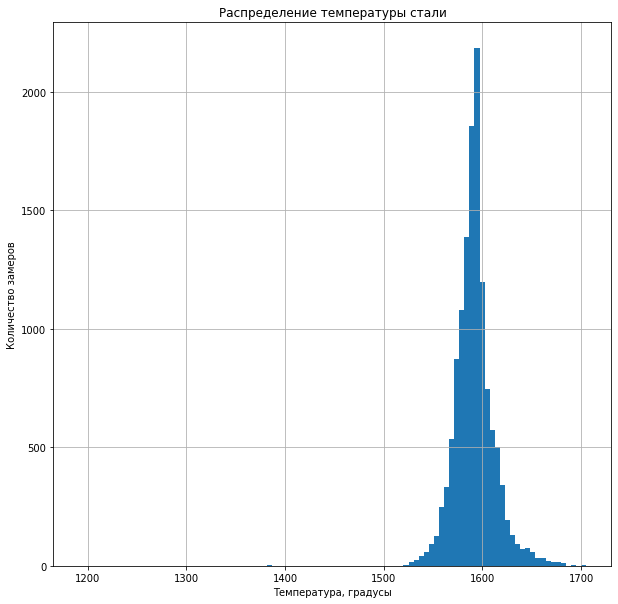

In [32]:
data_temp['temp'].hist(bins=100, figsize=(10,10))
plt.xlabel('Температура, градусы')
plt.ylabel('Количество замеров')
plt.title('Распределение температуры стали')
plt.show()

По гистограмме видно, что распределение температуры близко к нормальному и что практически все значения температуры лежат в диапазоне от 1500 до 1700 градусов. Посмотрим по диаграмме размаха на редкие значения.

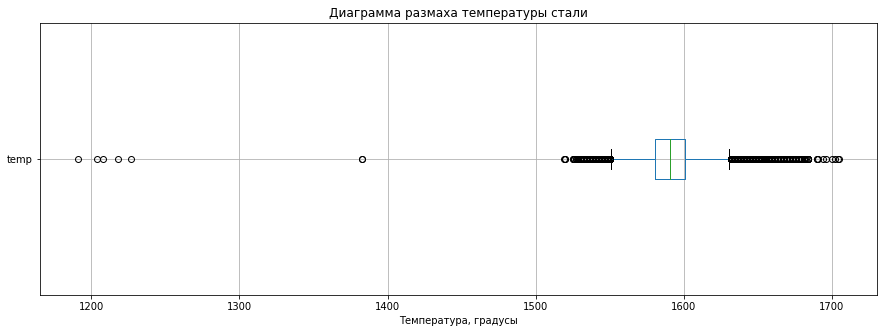

In [33]:
data_temp.boxplot(column='temp', figsize=(15, 5), vert=0)
plt.xlabel('Температура, градусы')
plt.title('Диаграмма размаха температуры стали')
plt.show()

На диаграмме размаха хорошо видно, что значения ниже 1500 градусов единичны, сильно разбросаны и далеко выходят за пределы усов. Значений выше 1700 градусов несколько больше, и они находятся близко друг к другу. Следует уточнить у заказчика, уместно ли удалить ключи с температурами ниже 1500 градусов.

Посмотрим на ключи записей, содержащих пропуски в температуре:

In [34]:
data_temp[data_temp['temp'].isna()].groupby('key')['key'].count()

key
2500    3
2501    4
2502    6
2503    3
2504    2
       ..
3237    4
3238    2
3239    7
3240    7
3241    4
Name: key, Length: 739, dtype: int64

Пропуски в температуре содержатся в ключах, начиная с 2500 и до конца. Восстановить значения не получится, т.к. у нас нет данных о партиях. Значит, эти ключи придётся исключить из дальнейшей работы.

### 1.6 Данные об объёме проволочных материалов

In [35]:
# чтение файла с данными об объёме проволочных материалов
data_wire = pd.read_csv('/final_steel/data_wire.csv')
    
# просмотр первых пяти строк полученной таблицы
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# получение общей информации о данных
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


В таблице 3081 запись, 10 признаков:
- `key` - номер партии;
- `Wire 1` ... `Wire 9` - объёмы подачи проволочных материалов 1...9.

В данных об объёмах подачи проволочных материалов присутствуют пропуски, т.к. в разные партии на разных итерациях подаются различные материалы. Пропуски позже заполним нулями.

Типы данных соответствуют по смыслу признакам.

Названия признаков следует дать в змеином регистре.

In [37]:
# переименование признаков
data_wire = data_wire.rename(columns={'Wire 1':'wire_1',
                                      'Wire 2':'wire_2',
                                      'Wire 3':'wire_3',
                                      'Wire 4':'wire_4',
                                      'Wire 5':'wire_5',
                                      'Wire 6':'wire_6',
                                      'Wire 7':'wire_7',
                                      'Wire 8':'wire_8',
                                      'Wire 9':'wire_9'}
                            )
# просмотр названий признаков
data_wire.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

Признаки переименованы.

In [38]:
# получение характерных значений количественных признаков
data_wire.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


В таблице присутствуют данные о 3081 ключе, т.е. представлены не все ключи (всего их 3214).

Явных ошибок в объёмах проволочных материалов не выявлено.

### 1.7 Данные о времени подачи проволочных материалов

In [39]:
# чтение файла с данными о времени подачи проволочных материалов
data_wire_time = pd.read_csv('/final_steel/data_wire_time.csv')
    
# просмотр первых пяти строк полученной таблицы
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# получение общей информации о данных
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


В таблице 3081 запись, 10 признаков:
- `key` - номер партии;
- `Wire 1` ... `Wire 9` - время подачи проволочных материалов 1...9.

В данных о времени подачи проволочных материалов также присутствуют пропуски, т.к. в разные партии на разных итерациях подаются различные материалы. Пропуски можно заполнить нулями, однако, данная таблица в дальнейшем не будет использована, поэтому заполнение не требуется. По этой же причине названия признаков к змеиному регистру приводить не будем.

Приведём лишь данные о времени к типу даты и времени, чтобы убедиться, что временные диапазоны соответствуют остальным таблицам.

In [41]:
data_wire_time[['Wire 1', 'Wire 2',
                'Wire 3', 'Wire 4',
                'Wire 5', 'Wire 6',
                'Wire 7', 'Wire 8',
                'Wire 9']] = data_wire_time[['Wire 1', 'Wire 2',
                                             'Wire 3', 'Wire 4',
                                             'Wire 5', 'Wire 6',
                                             'Wire 7', 'Wire 8',
                                             'Wire 9']].apply(pd.to_datetime)
data_wire_time.dtypes

key                int64
Wire 1    datetime64[ns]
Wire 2    datetime64[ns]
Wire 3    datetime64[ns]
Wire 4    datetime64[ns]
Wire 5    datetime64[ns]
Wire 6    datetime64[ns]
Wire 7    datetime64[ns]
Wire 8    datetime64[ns]
Wire 9    datetime64[ns]
dtype: object

Тип данных изменён. Посмотрим на минимальное и максимальное время подачи сыпучих материалов.

In [42]:
# просмотр минимального значения времени
data_wire_time[['Wire 1', 'Wire 2', 'Wire 3',
                'Wire 4', 'Wire 5', 'Wire 6',
                'Wire 7', 'Wire 8', 'Wire 9']].min().min()

Timestamp('2019-05-03 11:11:41')

In [43]:
# просмотр максимального значения времени
data_wire_time[['Wire 1', 'Wire 2', 'Wire 3',
                'Wire 4', 'Wire 5', 'Wire 6',
                'Wire 7', 'Wire 8', 'Wire 9']].max().max()

Timestamp('2019-09-01 04:16:01')

Данные о времени подачи проволочных материалов представлены за период с 11:11:41 3 мая по 04:16:01 1 сентября 2019 года, что согласуется со временем нагрева и подачи сыпучих материалов.

### 1.8 Вывод

1. Для анализа представлены 7 таблиц с данными, описывающими технологический процесс обработки стали.

<b>Данные об электродах содержат информацию о:</b>
- номере партии,
- времени начала и конца прогрева дугой,
- активной и реактивной мощности.

В таблице 14876 записей, при этом партий (ключей) 3214: из-за того, что обработка партии происходит в несколько итераций, на каждый ключ приходится по несколько записей. Данные по ключам необходимо будет агрегировать. 

Пропусков и явных ошибок нет, кроме одного отрицательного значения реактивной мощности. Ключ, содержащий это значение, удалён.

<b>Данные об объёме подачи сыпучих материалов содержат информацию о:</b>
- номере партии,
- объёме добавленного сыпучего материала 1...15.

В таблице 3129 записей, т.е. записи о некоторых ключах отсутствуют.

В данных об объёмах подачи сыпучих материалов присутствуют пропуски, т.к. в разные партии на разных итерациях подаются различные материалы. Пропуски позже заполним нулями. Явных ошибок нет.

<b>Данные о времени подачи сыпучих материалов содержат информацию о:</b>
- номере партии,
- времени добавления сыпучего материала 1...15.

В таблице, также как и в предыдущей, 3129 записей, т.е. записи о некоторых ключах отсутствуют.

Также присутствуют пропуски; их количество по каждому сыпучему материалу совпадает с количеством пропусков предыдущей таблицы: если материал не добавляли, то и время его добавления отсутствует. Данная таблица в дальнейшем не понадобится, пропуски заполнять не нужно.

<b>Данные о продувке сплава газом содержат информацию о:</b>
- номере партии,
- объёме поданного газа.

В таблице 3239 записей, имеются данные по ключам, отсутствующим в данных об электродах (там ключей 3213).

Пропусков и явных ошибок нет.

<b>Результаты измерения температуры содержат информацию о:</b>
- номере партии,
- времени замера,
- температуре.

В таблице 15907 записей, на каждый ключ приходится по несколько записей. Для исследования представляют интерес начальная и конечная температура стали, являющаяся целевым признаком.

В данных имеются пропуски значений температуры. Они содержатся в ключах, начиная с 2500 и до конца. Восстановить значения не получится, т.к. у нас нет данных о химическом составе ключей, на основе которых можно было бы попытаться восстановить температуру. Значит, эти ключи придётся исключить из дальнейшей работы.

Распределение температуры близко к нормальному и практически все значения температуры лежат в диапазоне от 1500 до 1700 градусов. При этом значения ниже 1500 градусов единичны, сильно разбросаны и далеко выходят за пределы усов. Значений выше 1700 градусов несколько больше, и они находятся близко друг к другу. Следует уточнить у заказчика, уместно ли удалить ключи с температурами ниже 1500 градусов.

<b>Данные об объёме проволочных материалов содержат информацию о:</b>
- номере партии,
- объёме добавленного проволочного материала 1...9.

В таблице 3081 запись, т.е. записи о некоторых ключах отсутствуют.

В данных об объёмах подачи проволочных материалов присутствуют пропуски, т.к. в разные партии на разных итерациях подаются различные материалы. Пропуски позже заполним нулями. Явных ошибок нет.

<b>Данные о времени подачи проволочных материалов содержат информацию о:</b>
- номере партии,
- времени добавления проволочных материала 1...15.

В таблице, также как и в предыдущей, 3081 запись, т.е. записи о некоторых ключах отсутствуют.

Также присутствуют пропуски; их количество по каждому проволочному материалу совпадает с количеством пропусков предыдущей таблицы: если материал не добавляли, то и время его добавления отсутствует. Данная таблица в дальнейшем не понадобится, пропуски заполнять не нужно.

2. Во всех таблицах названия признаков приведены к змеиному регистру. Тип признаков, содержащих время, приведён к типу даты и времени.


3. В таблицах содержится информация за временной интервал с 11 утра 3 мая по 4 утра 1 сентября 2019 года.


4. В дальнейшем для работы все таблицы необходимо объединить в одну сводную по ключам так, чтобы каждая запись сводной таблицы содержала информацию об одном уникальном ключе. При этом в сводную таблицу войдут только те ключи, информация по которым содержится во всех 7 таблицах.

## 2 Предобработка данных

Для того, чтобы модель могла предсказывать температуру стали в партии, необходимо обработать имеющиеся данные:
- создать новые признаки, пригодные для обучения модели;
- заменить пропуски или удалить данные с ними;
- агрегировать данные по ключам, так как в данных об электродах, а также в результатах измерения температуры на каждый ключ приходится по несколько наблюдений из-за итеративности процесса;
- создать сводную таблицу со всеми признаками, отобранными для обучения.

Данные о времени подачи сыпучих и проволочных материалов для обучения модели не нужны.

Данные о продувке сплава газом не требуют предобработки. С остальными данными надо поработать.

### 2.1 Работа с данными об электродах

В данных об электродах содержится информация о времени начала и конца нагрева дугой. В таком виде признаки не пригодны для использования моделью. Посчитаем длительность нагрева в секундах и добавим в таблицу новый признак:

In [44]:
print(data_arc.shape)
data_arc['heat_duration'] = (data_arc['arc_heat_end'] - data_arc['arc_heat_start']).dt.seconds.astype('int64')
print(data_arc.shape)
data_arc.head(5)

(14872, 5)
(14872, 6)


,key,arc_heat_start,arc_heat_end,act_power,react_power,heat_duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148


Длительность нагрева в секундах добавлена в таблицу.

Построим матрицу корреляции, чтобы проверить, как имеющиеся признаки коррелируют между собой.

In [45]:
corr = data_arc.corr()
corr.style.background_gradient(cmap='Greens').set_precision(2)

,key,act_power,react_power,heat_duration
key,1.00,-0.02,-0.00,-0.02
act_power,-0.02,1.00,0.96,0.97
react_power,-0.00,0.96,1.00,0.97
heat_duration,-0.02,0.97,0.97,1.00


По матрице видно, что и активная, и реактивная мощности, и время нагрева сильно коррелируют. Значит, использовать все три признака вместе нельзя. Попробуем создать новые признаки и на основе корреляции выберем из них те, на которых будет обучаться модель.

Посчитаем соотношение активной и реактивной мощностей и добавим в таблицу новый признак:

In [46]:
print(data_arc.shape)
data_arc['power_ratio'] = data_arc['act_power'] / data_arc['react_power']
print(data_arc.shape)
data_arc.head(5)

(14872, 6)
(14872, 7)


,key,arc_heat_start,arc_heat_end,act_power,react_power,heat_duration,power_ratio
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.420582
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,1.548395
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,1.492292
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.561504
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,1.671717


Соотношение посчитано, признак добавлен в таблицу.

Посчитаем общую мощность и добавим её в таблицу:

In [47]:
print(data_arc.shape)
data_arc['total_power'] = (data_arc['act_power']**2 + data_arc['react_power']**2)**0.5
print(data_arc.shape)
data_arc.head(5)

(14872, 7)
(14872, 8)


,key,arc_heat_start,arc_heat_end,act_power,react_power,heat_duration,power_ratio,total_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.420582,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,1.548395,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,1.492292,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.561504,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,1.671717,0.807239


Общая мощнось посчитана и добавлена в таблицу.

Посчитаем работу и также добавим её в таблицу:

In [48]:
print(data_arc.shape)
data_arc['work'] = data_arc['heat_duration'] * data_arc['total_power']
print(data_arc.shape)
data_arc.head(5)

(14872, 8)
(14872, 9)


,key,arc_heat_start,arc_heat_end,act_power,react_power,heat_duration,power_ratio,total_power,work
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.420582,1.193639,272.149755
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,1.548395,0.959010,177.416785
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,1.492292,0.896038,154.118502
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.561504,1.970470,719.221394
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,1.671717,0.807239,119.471318


Работа посчитана и добавлена в таблицу.

Построим ещё раз матрицу корреляции с новыми признаками:

In [49]:
corr = data_arc.corr()
corr.style.background_gradient(cmap='Greens').set_precision(2)

,key,act_power,react_power,heat_duration,power_ratio,total_power,work
key,1.00,-0.02,-0.00,-0.02,-0.09,-0.01,-0.01
act_power,-0.02,1.00,0.96,0.97,0.03,0.99,0.93
react_power,-0.00,0.96,1.00,0.97,-0.20,0.99,0.93
heat_duration,-0.02,0.97,0.97,1.00,-0.08,0.98,0.93
power_ratio,-0.09,0.03,-0.20,-0.08,1.00,-0.06,-0.05
total_power,-0.01,0.99,0.99,0.98,-0.06,1.00,0.94
work,-0.01,0.93,0.93,0.93,-0.05,0.94,1.00


По матрице видно, что из всех признаков корреляция отсутствует у продолжительности нагрева и отношения активной и реактивной мощностей. Значит, для обучения модели оставим только эти признаки.

Выведем для сравнения характерные значения признака `power_ratio` перед созданием сводной таблицы.

In [50]:
data_arc['power_ratio'].describe()

count    14872.000000
mean         1.360652
std          0.173105
min          0.457980
25%          1.257090
50%          1.376057
75%          1.480514
max          1.949831
Name: power_ratio, dtype: float64

Создадим сводную таблицу с группировкой по ключам, суммарной мощностью и медианным соотношением активной и реактивной мощностей для каждого ключа:

In [51]:
arc_pivot = data_arc.pivot_table(index='key',
                                 values=('heat_duration', 'power_ratio'),
                                 aggfunc={'heat_duration':'sum',
                                          'power_ratio':'median'}).reset_index()
arc_pivot.columns = ['key', 'heat_dur_sum', 'power_ratio_median']
arc_pivot.head()

,key,heat_dur_sum,power_ratio_median
0,1,1098,1.548395
1,2,811,1.574566
2,3,655,1.581626
3,4,741,1.601656
4,5,869,1.499092


Создана таблица с наблюдениями, соответствующими уникальным ключам. Для каждого ключа посчитано суммарное время нагрева и медианное отношение активной и реактивной мощностей.

Посмотрим на характерные значения признака `power_ratio` после создания сводной таблицы:

In [52]:
arc_pivot['power_ratio_median'].describe()

count    3213.000000
mean        1.371198
std         0.145075
min         0.591452
25%         1.298891
50%         1.384662
75%         1.461785
max         1.894052
Name: power_ratio_median, dtype: float64

Характерные значения отношения мощностей изменились не сильно, признак можно использовать в работе.
- Диапазон значений и стандартное отклонение несколько уменьшились: было 0,46...1,95 и 0,17, стало 0,59...1,89 и 0,14;
- среднее и медиана изменились на 0,01: с 1,36 на 1,37 и с 1,37 на 1,38.

### 2.2 Работа с результатами измерения температуры

Ранее мы видели, что в ключах, начиная с 2500, есть пропуски в значениях температуры. Если пропуски в первой или последней температурах по времени, это не позволит использовать данные по таким ключам. Заменим пропуски на нули, чтобы корректно отобрать начальную и конечную температуры. После группировки удалим ключи с нулевыми температурами.

In [53]:
print(data_temp.isna().sum())
data_temp = data_temp.fillna(0)
data_temp.isna().sum()

key             0
time_temp       0
temp         2901
dtype: int64


key          0
time_temp    0
temp         0
dtype: int64

Пропуски заменены на нули. Теперь сгруппируем данные по ключам и создадим новые признаки для каждого из них: начальную и конечную температуры стали.

In [54]:
temp_pivot = data_temp.pivot_table(index='key',
                                   values='temp',
                                   aggfunc=('first', 'last')).reset_index()
temp_pivot.columns = ['key', 'first_temp', 'last_temp']
temp_pivot.head()

,key,first_temp,last_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


Мы получили сводную таблицу с данными о начальной и конечной температуре стали каждого ключа. Посмотрим на характерные значения полученных признаков.

In [55]:
temp_pivot.describe()

,key,first_temp,last_temp
count,3216.000000,3216.000000,3216.000000
mean,1622.199316,1588.592040,1228.744714
std,935.088523,29.137454,671.403549
min,1.000000,1191.000000,0.000000
25%,815.750000,1572.000000,1574.000000
50%,1622.500000,1588.000000,1590.000000
75%,2431.250000,1606.000000,1597.000000
max,3241.000000,1684.000000,1700.000000


Часть пропусков оказалась в конечной температуре: минимальное значение признака равно нулю. Удалим ключи с нулевой конечной температурой:

In [56]:
print(temp_pivot.shape)
temp_pivot = temp_pivot[temp_pivot.last_temp != 0]
temp_pivot.shape

(3216, 3)


(2477, 3)

Ключи с нулевой конечной температурой удалены.

По уточнённым данным от заказчика, ключи с начальной температурой ниже 1500 градусов также следует удалить, чтобы повысить точность предсказаний. Для низких температур предполагается сделать отдельную модель. Удаляем:

In [57]:
temp_pivot = temp_pivot[temp_pivot.first_temp >= 1500]
temp_pivot.shape

(2473, 3)

Ключи с начальной температурой ниже 1500 градусов удалены.

### 2.3 Работа с данными об объёме подачи сыпучих и проволочных материалов

В данных много пропусков, т.к. в разные ключи добавляют разные сыпучие и проволочные материалы. Пропуски показывают, что данный сыпучий или проволочный материал в ключ не добавляли. Значит, их можно заменить на нули.

Также среди сыпучих материалов есть материал `bulk_8`, а среди проволочных - `wire_5`, которые были добавлен только по одному разу. Такие признаки будут неинформатвны, лучше их удалить.

In [58]:
# удаление сыпучего материала bulk_8
print(data_bulk.shape)
data_bulk = data_bulk.drop(columns=['bulk_8'])
data_bulk.shape

(3129, 16)


(3129, 15)

In [59]:
# удаление проволочного материала wire_5
print(data_wire.shape)
data_wire = data_wire.drop(columns=['wire_5'])
data_wire.shape

(3081, 10)


(3081, 9)

Признаки удалены. Теперь заменим все пропуски на нули.

In [60]:
# замена пропусков на нули в данных о сыпучих материалах
print(data_bulk.isna().sum())
data_bulk = data_bulk.fillna(0)
data_bulk.isna().sum()

key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64


key        0
bulk_1     0
bulk_2     0
bulk_3     0
bulk_4     0
bulk_5     0
bulk_6     0
bulk_7     0
bulk_9     0
bulk_10    0
bulk_11    0
bulk_12    0
bulk_13    0
bulk_14    0
bulk_15    0
dtype: int64

In [61]:
# замена пропусков на нули в данных о проволочных материалах
print(data_wire.isna().sum())
data_wire = data_wire.fillna(0)
data_wire.isna().sum()

key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64


key       0
wire_1    0
wire_2    0
wire_3    0
wire_4    0
wire_6    0
wire_7    0
wire_8    0
wire_9    0
dtype: int64

Пропуски заменены на нули.

### 2.4 Создание сводной таблицы

Объединим в сводную таблицу по ключам данные о длительности нагрева и отношении мощностей, о начальной и конечной температурах, об объёмах подаваемых газа, сыпучего и проволочного материалов.

Объединять будем так, чтобы в сводную таблицу попали только те ключи, данные о которых есть во всех объединяемых таблицах.

In [62]:
df = arc_pivot.merge(temp_pivot, on='key')
df = df.merge(data_gas, on='key')
df = df.merge(data_bulk, on='key')
df = df.merge(data_wire, on='key')
display(df.head(10))
df.shape

,key,heat_dur_sum,power_ratio_median,first_temp,last_temp,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,1098,1.548395,1571.0,1613.0,29.749986,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,811,1.574566,1581.0,1602.0,12.555561,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,655,1.581626,1596.0,1599.0,28.554793,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,741,1.601656,1601.0,1625.0,18.841219,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,869,1.499092,1576.0,1602.0,5.413692,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0
5,6,952,1.530188,1543.0,1596.0,11.273392,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,201.0,154.0,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0
6,7,673,1.632877,1586.0,1599.0,9.836267,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,152.0,154.0,98.061600,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7,8,913,1.559012,1577.0,1598.0,15.171553,0.0,0.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,410.0,0.0,252.0,153.0,155.282394,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
8,9,625,1.457549,1587.0,1592.0,8.216623,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,99.0,203.0,113.393279,9.143681,0.0,0.0,0.0,0.0,0.0,0.0
9,10,825,1.244260,1574.0,1593.0,6.529891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,102.0,204.0,81.244796,12.376000,0.0,0.0,0.0,0.0,0.0,0.0


(2324, 28)

Мы получили сводную таблицу, каждое из 2324 наблюдений которой содержит информацию об уникальном ключе.

В таблице 28 признаков, один из которых - конечная температура - является целевым.

Ещё один признак - номер партии - для обучения не нужен, удалим его позже.

Посмотрим на корреляцию полученных признаков.

In [63]:
corr_df = df.corr()
corr_df.style.background_gradient(cmap='Greens').set_precision(2)

,key,heat_dur_sum,power_ratio_median,first_temp,last_temp,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
key,1.00,-0.03,-0.13,-0.02,-0.10,-0.04,-0.08,-0.01,-0.01,-0.03,0.04,0.01,0.05,-0.04,0.06,0.04,0.03,-0.02,-0.11,-0.04,-0.01,0.04,-0.03,0.05,-0.01,0.04,-0.04,0.02
heat_dur_sum,-0.03,1.00,0.10,-0.38,0.28,0.40,0.10,0.04,0.09,-0.03,0.01,0.16,0.08,0.01,-0.01,0.08,0.47,0.13,0.46,0.29,0.06,0.05,0.03,0.05,0.04,0.03,0.02,-0.01
power_ratio_median,-0.13,0.10,1.00,-0.10,0.18,0.09,-0.10,-0.05,0.15,0.02,-0.03,0.02,-0.04,0.05,0.02,-0.02,0.10,-0.00,0.15,0.14,0.13,0.00,0.02,-0.03,-0.01,-0.04,0.05,-0.00
first_temp,-0.02,-0.38,-0.10,1.00,0.30,0.04,0.08,0.14,-0.11,0.17,0.08,-0.13,0.09,-0.03,0.04,-0.11,-0.08,0.02,-0.18,-0.06,0.26,-0.10,-0.00,0.08,0.02,0.05,-0.03,0.00
last_temp,-0.10,0.28,0.18,0.30,1.00,0.06,-0.08,-0.08,-0.04,0.19,-0.03,-0.18,-0.11,-0.02,0.06,-0.11,0.27,-0.01,0.11,0.27,0.32,-0.21,-0.05,-0.16,-0.08,-0.14,-0.01,-0.03
gas_1,-0.04,0.40,0.09,0.04,0.06,1.00,0.23,0.22,0.06,0.02,0.09,0.14,0.20,0.12,-0.01,0.04,0.22,0.05,0.27,0.04,0.12,0.10,0.10,0.15,0.11,0.08,0.12,0.01
bulk_1,-0.08,0.10,-0.10,0.08,-0.08,0.23,1.00,0.22,-0.01,0.04,0.06,-0.00,0.24,-0.02,-0.02,-0.04,0.33,-0.01,0.21,-0.00,0.01,-0.01,0.02,0.15,0.15,0.08,-0.02,0.01
bulk_2,-0.01,0.04,-0.05,0.14,-0.08,0.22,0.22,1.00,-0.05,0.04,0.36,-0.03,0.68,-0.01,-0.02,0.00,-0.10,-0.01,-0.14,-0.11,-0.17,-0.04,0.22,0.70,0.56,0.43,-0.01,-0.01
bulk_3,-0.01,0.09,0.15,-0.11,-0.04,0.06,-0.01,-0.05,1.00,-0.30,-0.01,0.07,-0.03,0.01,-0.09,-0.01,0.02,-0.01,0.01,-0.01,0.04,0.09,0.01,-0.04,0.01,-0.02,0.00,0.00
bulk_4,-0.03,-0.03,0.02,0.17,0.19,0.02,0.04,0.04,-0.30,1.00,0.03,-0.25,0.05,-0.00,-0.08,-0.12,0.11,0.00,-0.09,0.10,0.30,-0.27,-0.04,0.03,-0.01,0.03,0.01,-0.06


Мы получили несколько признаков с сильной корреляцией:
- `bulk_9` и `wire_8`: 0,97;
- `bulk_7` и `wire_4`: 0,74;
- `bulk_2` и `wire_4`: 0,7.

У всех этих признаков много нулевых значений. Удалим из каждой пары по одному признаку, а заодно, и номер партии.

In [64]:
df = df.drop(['key', 'bulk_9', 'wire_4'], axis=1)
df.shape

(2324, 25)

Признаки удалены.

### 2.5 Вывод

Произведена предобработка данных.

1. Рассчитаны и сгруппированы по ключам суммарное время нагрева и медианное отношение активной и реактивной мощностей.
2. Для каждого ключа определены начальная и конечная температуры.
3. Ключи с нулевой конечной температурой и начальной ниже 1500 градусов удалены.
4. Удалены сыпучий и проволочный материалы, добавлявшиеся по одному разу; для остальных материалов пропуски заменены на нули.
5. Собраны в сводную таблицу по ключам данные о длительности нагрева и отношении мощностей, о начальной и конечной температурах, об объёмах подаваемых газа, сыпучего и проволочного материалов.
6. Из сводной таблицы удалены признаки с высокой корреляцией, а также номер партии.
7. Сводная таблица содержит 2324 наблюдения, соответствующие уникальным ключам, и 25 признаков.

## 3 Обучение и выбор лучшей модели

Подберём лучшие гиперпараметры и обучим линейную регрессиию, дерево решений, случайный лес, модель градиентного бустинга. Для проверки адекватности моделей обучим также константную модель.

Метрика качества - <i>MAE</i>, значение должно быть не выше 6,8. 

### 3.1 Подготовка к обучению

Разделим данные на обучающую и тестовую выборки в соотношении 75:25.

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['last_temp'], axis=1),
    df['last_temp'], test_size=0.25, random_state=rs)

print(f'Размер признаков обучающей выборки: {X_train.shape}')
print(f'Размер целевого признака обучающей выборки: {y_train.shape}')
print(f'Размер признаков тестовой выборки: {X_test.shape}')
print(f'Размер целевого признака тестовой выборки: {y_test.shape}')

Размер признаков обучающей выборки: (1743, 24)
Размер целевого признака обучающей выборки: (1743,)
Размер признаков тестовой выборки: (581, 24)
Размер целевого признака тестовой выборки: (581,)


Данные разделены корректно.

Для обучения моделей и подбора гиперпараметров напишем собственную функцию с использованием <i>Pipeline</i> и <i>GridSearch</i>.

In [66]:
# создание функции для подбора параметров лучшей модели
def pipeline(model, X, y, params):
  '''
  функция для подбора лучших гиперпараметров и обучения модели:
  на вход принимает модель с параметрами, признаки и целевой признак,
  возвращает значение MAE на обучающей выборке, лучшую модель и
  выводит на экран значение MAE и подобранные гиперпараметры
  '''
  pipe = Pipeline([('model', model)])
  param = params

  grid = GridSearchCV(pipe, param,
                      scoring='neg_mean_absolute_error',
                      cv=5)
  
  grid.fit(X, y)

  print('Лучшее значение MAE:', grid.best_score_)
  print('Лучшие параметры', grid.best_params_)
  
  return grid.best_score_, grid

### 3.2 Линейная регрессия

Обучим линейную регрессию с использованием <i>pipeline</i> и кросс-валидации. Внутри <i>pipeline</i> произведём масштабирование признаков, чтобы алгоритм не выделял на основе порядка и разброса одни признаки как более важные, другие - как менее важные.

In [67]:
# создание объекта pipeline
pipe_lr = Pipeline([
    ('ss', StandardScaler()),
    ('linreg', LinearRegression())
])
# получение оценок кросс-валидацией
scores = cross_val_score(pipe_lr, X_train, y_train, scoring = 'neg_mean_absolute_error', cv=5)
print('MAE =', abs(scores.mean()))

MAE = 6.669536913278253


Получили неплохое значение метрики. Посмотрим, как справятся с задачей остальные модели.

### 3.3 Дерево решений

In [68]:
%%time
# инициализация модели дерева решений 
model_dt = DecisionTreeRegressor(random_state=rs)

# установка диапазонов гиперпараметров
param_dt = {'model__max_depth': range(2, 15),
            'model__min_samples_leaf': [2, 5]}

# получение лучших значений метрики, гиперпараметров и лучшей модели
score_dt, best_model_dt = pipeline(model_dt, X_train, y_train, param_dt)

Лучшее значение MAE: -7.199360797033611
Лучшие параметры {'model__max_depth': 5, 'model__min_samples_leaf': 5}
Wall time: 2.23 s


Значение метрики хуже, чем у линейной регрессии.

### 3.4 Случайный лес

In [69]:
%%time
# инициализация модели случайного леса
model_rf = RandomForestRegressor(random_state=rs)

# установка диапазонов гиперпараметров
param_rf = {'model__n_estimators': range(10, 15),
            'model__max_depth': range(2, 11)}

# получение лучших значений метрики, гиперпараметров и лучшей модели
score_rf, best_model_rf = pipeline(model_rf, X_train, y_train, param_rf)

Лучшее значение MAE: -6.191586251255837
Лучшие параметры {'model__max_depth': 9, 'model__n_estimators': 12}
Wall time: 18.4 s


Значение метрики лучше, чем у линейной регрессии и дерева решений.

### 3.5 <i>CatBoostRegressor</i>

In [70]:
%%time
# инициализация модели CatBoostRegressor
model_cbr = CatBoostRegressor(iterations=150, random_state=rs, verbose=False)

# установка диапазонов гиперпараметров
param_cbr = {'model__depth': range(2, 7),
             'model__learning_rate': [0.05, 0.1, 0.15]}

# получение лучших значений метрики, гиперпараметров и лучшей модели
score_cbr, best_model_cbr = pipeline(model_cbr, X_train, y_train, param_cbr)

Лучшее значение MAE: -5.993749049429274
Лучшие параметры {'model__depth': 6, 'model__learning_rate': 0.1}
Wall time: 30.2 s


Модель градиентного бустинга получила наилучшую метрику: <i>MAE</i> = 5,99.

### 3.6 Константная модель

In [71]:
%%time
# инициализация константной модели
model_dummy = DummyRegressor(quantile=1.0)

# установка диапазонов гиперпараметров
param_dummy = {'model__strategy': ['mean', 'median', 'quantile']}

# получение лучших значений метрики, гиперпараметров и лучшей модели
score_dummy, best_model_dummy = pipeline(model_dummy, X_train, y_train, param_dummy)

Лучшее значение MAE: -8.030685373645555
Лучшие параметры {'model__strategy': 'median'}
Wall time: 42 ms


Значение метрики константной модели хуже, чем у всех рассмотренных моделей, значит, они адекватны.

### 3.7 Вывод

Данные разделены на обучающую и тестовую выборки в соотношении 75:25.

Метрика качества - <i>MAE</i>, значение должно быть не выше 6,8.

Обучены линейная регрессиия, дерево решений, случайный лес, модель градиентного бустинга, константная модель.

Лучшее значение метрики - 5,99 - показала модель <i>CatBoostRegressor</i> при 150 итерациях, с глубиной деревьев, равной 6, и скоростью обучения 0,1.

Затем следует случайный лес - 6,19, линейная регрессия - 6,67  и дерево решений - 7,2.

Константная модель показала худшее значение метрики - 8,03, значит, обученные модели адекватны.

## 4 Проверка качества модели на тестовой выборке

Получим предсказания модели <i>CatBoostRegressor</i> на тестовой выборке и рассчитаем <i>MAE</i>.

In [72]:
# получение предсказаний лучшей модели и расчёт mae
predict_cbr = best_model_cbr.predict(X_test)
mae_cbr = mean_absolute_error(y_test, predict_cbr)
mae_cbr

6.2796664763882255

Значение метрики на тестовой выборке несколько хуже, чем на обучающей - 6,28.

### 4.1 Вывод

На тестовой выборке лучшей моделью - <i>CatBoostRegressor</i> - получено <i>MAE</i> = 6,28.

## 5 Общий вывод

1. Для анализа представлены 7 таблиц с данными, описывающими технологический процесс обработки стали.
- данные об электродах содержат информацию о прогреве партий стали (ключей) дугой на разных итерациях;
- данные об объёме и времени подачи сыпучих материалов содержат информацию о процессе добавления 15 сыпучих легирующих материалов в ключи;
- данные о продувке сплава газом содержат информацию об объёме газа, поданного в ключи;
- результаты измерения температуры содержат информацию о температуре ключей на разных итерациях;
- данные об объёме и времени подачи проволочных материалов содержат информацию о процессе добавления 9 проволочных легирующих материалов в ключи.
2. Произведён анализ данных.
-  Не все ключи присутствуют во всех таблицах.
- Во всех таблицах названия признаков приведены к змеиному регистру. Тип признаков, содержащих время, приведён к типу даты и времени. Тип остальных признаков соответствует по смыслу содержимому.
- В таблицах содержится информация за временной интервал с 11 утра 3 мая по 4 утра 1 сентября 2019 года.
- В данных об электродах обнаружено одно отрицательное значение реактивной мощности. Ключ, содержащий это значение, удалён.
- Распределение температуры близко к нормальному и практически все значения температуры лежат в диапазоне от 1500 до 1700 градусов. При этом значения ниже 1500 градусов единичны, сильно разбросаны и далеко выходят за границы доверительного интервала. Принято решение удалить ключи с начальной температурой ниже 1500 градусов, чтобы повысить точность предсказаний. Для низких температур предполагается сделать отдельную модель.
- Других явных ошибок в данных нет.
- Есть пропуски в темпаратурах ключей, начиная с 2500.
- В данных об объёме и времени подачи сыпучих и проволочных материалов много пропусков из-за того, что в разные ключи добавляют разные материалы.
3. Произведена предобработка данных.
- Рассчитаны и сгруппированы по ключам суммарное время нагрева и медианное отношение активной и реактивной мощностей.
- Для каждого ключа определены начальная и конечная температуры.
- Ключи с нулевой конечной температурой и начальной ниже 1500 градусов удалены.
- Удалены сыпучий и проволочный материалы, добавлявшиеся по одному разу; для остальных материалов пропуски заменены на нули.
- Собраны в сводную таблицу по ключам данные о длительности нагрева и отношении мощностей, о начальной и конечной температурах, об объёмах подаваемых газа, сыпучего и проволочного материалов.
- В сводную таблицу вошли только те ключи, информация о которых содержится во всех 7 исходных таблицах.
- Из сводной таблицы удалены признаки с высокой корреляцией, а также номер партии.
- Сводная таблица содержит 2324 наблюдения, соответствующие уникальным ключам, и 25 признаков.
4. Произведено обучение моделей.
- Данные разделены на обучающую и тестовую выборки в соотношении 75:25.
- Метрика качества - <i>MAE</i>, значение должно быть не выше 6,8.
- Обучены линейная регрессиия, дерево решений, случайный лес, модель градиентного бустинга, константная модель.
- Лучшее значение метрики - 5,99 - показала модель <i>CatBoostRegressor</i>.
- Затем следует случайный лес - 6,19, линейная регрессия - 6,67  и дерево решений - 7,2.
- Константная модель показала худшее значение метрики - 8,03, значит, обученные модели адекватны.
5. Произведена проверка качества выбранной модели на тестовой выборке.
- На тестовой выборке лучшей моделью - <i>CatBoostRegressor</i> - получено <i>MAE</i> = 6,28.
- Гиперпараметры лучшей модели: 150 итераций, глубина деревьев - 6, скорость обучения - 0,1.